<a href="https://colab.research.google.com/github/pedro-de-bastos/Capstone/blob/master/Genetic%20Matching%20and%20Linear%20Models%20for%20Sentiment%20Analysis%20Professor%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Clear the csv files
files <- list.files(pattern = "\\.csv$")
for (i in files){
  unlink(i)
}

# Assistant Functions

In [ ]:
#Importing Data
mcallister = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRRePaXIdFSa-WXiYgzl87iIxCR1d4E0JEFilXQnTkFdMe4UVHOyMmfNg-3D3A9Ou0UrpjIIm84Os8B/pub?output=csv")
terrana = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQS-_ZQGjTFt0ZktHmqMpuETw-1QUyWKMF1oMnYDMlAle6ZUdO5fqcLWStrDXB92LoSOgxk09fclTMu/pub?output=csv")
dosmann = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTEh7GtTQv7FcmWXG2XMRYfBoC5elUHzCGBvyheYuGrUUkAWQukiAW5x-oo2IsBiRWUfsTMqDjfWYZu/pub?output=csv")
fiorelli = read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQ12Q4mTk8b0cHKJ9w5K7TrSkjpfT-mKHJ7kJq213q_N_RsxMC1F686L-jXzCVnpQTcx6qzciPXj2vP/pub?output=csv")

## Creating CSV

In [ ]:
csv_to_mean_sd <- function(csv_name, inst_name){
  foo = read.csv(csv_name)
  names = unique(foo$Names)
  names = names[names!=inst_name]
  names = names[names!=""]
  talks <- c()
  for (i in names){
    subset = foo$Names==i
    talktime = sum(foo[subset,2])
    talks <- c(talks, talktime)
  }
  talks = talks[-1]
  return(talks)
}


### For Each Class A Prof. Teaches:

In [ ]:
#"Data" corresponds to the CSV files with the judgement score results

prof_talk_times <- function(data, inst_name){
  data$Judgement = data$Score*data$Magnitude
  files <- c('Class_1.1.csv', 'Class_1.2.csv', 'Class_2.1.csv', 'Class_2.2.csv', 'Class_3.1.csv', 'Class_3.2.csv', 'Class_4.1.csv', 'Class_4.2.csv', 'Class_5.1.csv', 'Class_5.2.csv', 'Class_6.2.csv', 'Class_7.1.csv', 'Class_7.2.csv', 'Class_8.1.csv', 'Class_8.2.csv', 'Class_9.1.csv', 'Class_9.2.csv', 'Class_10.1.csv', 'Class_10.2.csv')
  means = c()
  sds = c()

  for (i in files){
    means <- c(means, mean(csv_to_mean_sd(i, inst_name)))
    sds <- c(sds, sd(csv_to_mean_sd(i, inst_name)))
  }

  data$Talk_Means = means
  data$Talk_SDs = sds
  return (data)
}


## Genetic Matching

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
library(rbounds)
library(rgenoud)

gen_matching <- function(csv, outcome){
  ##Defining Treatment and Control
  foo = csv

  #treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
  #control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
  #vars = treat|control
  #foo = foo[vars,]
  foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
  foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
  foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

  for (i in 1:length(foo$Treat)){
    if (is.na(foo$Video.Mean[i])){
      foo$AvgGrade[i] = foo$Prep.Mean[i]
    } else if (is.na(foo$Prep.Mean[i])){
      foo$AvgGrade[i] = foo$Video.Mean[i]
    } else {
      foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
    }
  }

  for (i in 1:length(foo$Treat)){
    if (is.na(foo$Video.SD[i])){
      foo$AvgGradeSD[i] = foo$Prep.SD[i]
    } else if (is.na(foo$Prep.SD[i])){
      foo$AvgGradeSD[i] = foo$Video.SD[i]
    } else {
      foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
    }
  }
  foo = foo[!is.na(foo$AvgGrade),]

  Y = as.numeric(unlist(foo[outcome]))
  Tr = foo$Treat
  dates = as.Date(foo$Class.Date, "%m/%d/%Y")
  numerics = as.numeric(dates)
  X = cbind(numerics, foo$Number.of.Students, foo$AvgGradeSD, foo$AvgGrade) 
  genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", print.level=0, pop.size = 1000, replace = TRUE)
  mout = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)

  mb = MatchBalance(foo$Treat~numerics+foo$Number.of.Students+foo$AvgGradeSD+foo$AvgGrade, match.out = mout, print.level=0)
  smallestp = mb$AMsmallest.p.value
  
  print(mb$AMsmallest.p.value)
  summary(mout)
  return(mout)
}

# Prof McAllister

In [ ]:
mcallister = read.csv("mcallister.csv")

## Building CSV File

In [ ]:
mcallister = read_xlsx("McAllister_results.xlsx")
mcallister = prof_talk_times(mcallister, "Katie McAllister ")

ERROR: ignored

In [ ]:
##To 

foo = read.csv("emoji_hands.csv")
dates = unique(foo$Class.Date)
dates = dates[-(1:7)]
dates = rev(dates)
foo = foo[foo$Class.Date %in% dates,]
events <- c()
for (i in dates){
  events <- c(events, length(foo[foo$Class.Date==i,1]))
}

mcallister$Emojis_Handraises = events

In [ ]:
write.csv(mcallister, "mcallister.csv")

## Score Correlation Analysis

### Emojis/Handraises


In [ ]:
mcallister_score_1 = lm(mcallister$Emojis_Handraises~mcallister$Score)
summary(mcallister_score_1)
summary(mcallister_score_1)$r.squared


Call:
lm(formula = mcallister$Emojis_Handraises ~ mcallister$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.207 -15.293  -1.655  17.293  53.345 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       108.655      9.975  10.893 4.36e-09 ***
mcallister$Score  -72.759     50.204  -1.449    0.165    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24.81 on 17 degrees of freedom
Multiple R-squared:   0.11,	Adjusted R-squared:  0.05761 
F-statistic:   2.1 on 1 and 17 DF,  p-value: 0.1655


[1] 0.109963

### Talk Time Mean

In [ ]:
mcallister_score_2 = lm(mcallister$Talk_Means~mcallister$Score)
summary(mcallister_score_2)
summary(mcallister_score_2)$r.squared


Call:
lm(formula = mcallister$Talk_Means ~ mcallister$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.200 -22.273  -3.517  12.628 108.582 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        150.27      14.57  10.316  9.8e-09 ***
mcallister$Score    60.63      73.32   0.827     0.42    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 36.23 on 17 degrees of freedom
Multiple R-squared:  0.03867,	Adjusted R-squared:  -0.01788 
F-statistic: 0.6839 on 1 and 17 DF,  p-value: 0.4197


[1] 0.03867207

### Talk Time SD

In [ ]:
mcallister_score_3 = lm(mcallister$Talk_SDs~mcallister$Score)
summary(mcallister_score_3)
summary(mcallister_score_3)$r.squared


Call:
lm(formula = mcallister$Talk_SDs ~ mcallister$Score)

Residuals:
   Min     1Q Median     3Q    Max 
-68.94 -43.41 -22.00   4.76 350.39 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)        130.89      36.98   3.540  0.00252 **
mcallister$Score   173.97     186.10   0.935  0.36298   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 91.97 on 17 degrees of freedom
Multiple R-squared:  0.04889,	Adjusted R-squared:  -0.007057 
F-statistic: 0.8739 on 1 and 17 DF,  p-value: 0.363


[1] 0.04889023

## Magnitude Analysis

### Emojis/Handraises


In [ ]:
mcallister_mag_1 = lm(mcallister$Emojis_Handraises~mcallister$Magnitude)
summary(mcallister_mag_1)


Call:
lm(formula = mcallister$Emojis_Handraises ~ mcallister$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.641 -14.043  -5.245  15.255  31.572 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            62.025     15.065   4.117 0.000720 ***
mcallister$Magnitude    8.002      1.975   4.052 0.000829 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.76 on 17 degrees of freedom
Multiple R-squared:  0.4913,	Adjusted R-squared:  0.4614 
F-statistic: 16.42 on 1 and 17 DF,  p-value: 0.0008285


### Talk Time Mean

In [ ]:
mcallister_mag_2 = lm(mcallister$Talk_Means~mcallister$Magnitude)
summary(mcallister_mag_2)


Call:
lm(formula = mcallister$Talk_Means ~ mcallister$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.062 -21.691  -7.576   9.578 112.875 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          139.0228    29.6793   4.684 0.000213 ***
mcallister$Magnitude   0.1849     3.8907   0.048 0.962641    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 36.95 on 17 degrees of freedom
Multiple R-squared:  0.0001329,	Adjusted R-squared:  -0.05868 
F-statistic: 0.00226 on 1 and 17 DF,  p-value: 0.9626


### Talk Time SD

In [ ]:
mcallister_mag_3 = lm(mcallister$Talk_SDs~mcallister$Magnitude)
summary(mcallister_mag_3)


Call:
lm(formula = mcallister$Talk_SDs ~ mcallister$Magnitude)

Residuals:
   Min     1Q Median     3Q    Max 
-76.43 -43.07 -14.78  12.32 341.78 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)           159.585     74.354   2.146   0.0466 *
mcallister$Magnitude   -7.807      9.747  -0.801   0.4342  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 92.57 on 17 degrees of freedom
Multiple R-squared:  0.03637,	Adjusted R-squared:  -0.02032 
F-statistic: 0.6416 on 1 and 17 DF,  p-value: 0.4342


## Judgement Analysis

### Emojis/Handraises


In [ ]:
mcallister_judge_1 = lm(mcallister$Emojis_Handraises~mcallister$Judgement)
summary(mcallister_judge_1)


Call:
lm(formula = mcallister$Emojis_Handraises ~ mcallister$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.914 -15.979  -1.721  12.079  56.279 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           105.721      8.213  12.872 3.42e-10 ***
mcallister$Judgement  -11.181      4.773  -2.343   0.0316 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 22.86 on 17 degrees of freedom
Multiple R-squared:  0.244,	Adjusted R-squared:  0.1996 
F-statistic: 5.488 on 1 and 17 DF,  p-value: 0.03157


### Talk Time Mean

In [ ]:
mcallister_judge_2 = lm(mcallister$Talk_Means~mcallister$Judgement)
summary(mcallister_judge_2)


Call:
lm(formula = mcallister$Talk_Means ~ mcallister$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.746 -21.166  -1.841  11.127 108.219 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           146.951     13.111  11.208 2.84e-09 ***
mcallister$Judgement    4.966      7.619   0.652    0.523    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 36.5 on 17 degrees of freedom
Multiple R-squared:  0.02438,	Adjusted R-squared:  -0.03301 
F-statistic: 0.4248 on 1 and 17 DF,  p-value: 0.5233


### Talk Time SD

In [ ]:
mcallister_judge_3 = lm(mcallister$Talk_SDs~mcallister$Judgement)
summary(mcallister_judge_3)


Call:
lm(formula = mcallister$Talk_SDs ~ mcallister$Judgement)

Residuals:
   Min     1Q Median     3Q    Max 
-70.66 -42.33 -18.31   9.61 345.47 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)   
(Intercept)            127.46      32.95   3.868  0.00123 **
mcallister$Judgement    18.84      19.15   0.984  0.33889   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 91.73 on 17 degrees of freedom
Multiple R-squared:  0.05389,	Adjusted R-squared:  -0.00176 
F-statistic: 0.9684 on 1 and 17 DF,  p-value: 0.3389


## Plots

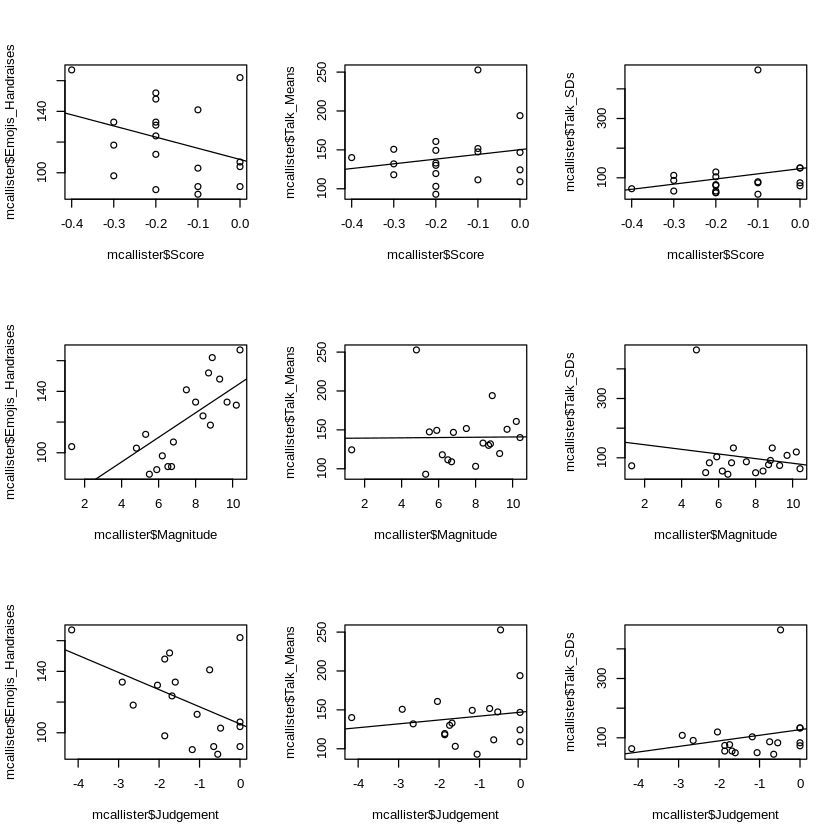

In [ ]:
par(mfrow=c(3,3))

#Score
plot(mcallister$Emojis_Handraises~mcallister$Score)
abline(mcallister_score_1)

plot(mcallister$Talk_Means~mcallister$Score)
abline(mcallister_score_2)

plot(mcallister$Talk_SDs~mcallister$Score)
abline(mcallister_score_3)

#Magnitude
plot(mcallister$Emojis_Handraises~mcallister$Magnitude)
abline(mcallister_mag_1)

plot(mcallister$Talk_Means~mcallister$Magnitude)
abline(mcallister_mag_2)

plot(mcallister$Talk_SDs~mcallister$Magnitude)
abline(mcallister_mag_3)

#Judgement
plot(mcallister$Emojis_Handraises~mcallister$Judgement)
abline(mcallister_judge_1)

plot(mcallister$Talk_Means~mcallister$Judgement)
abline(mcallister_judge_2)

plot(mcallister$Talk_SDs~mcallister$Judgement)
abline(mcallister_judge_3)

## Genetic Matching and Causation

### Effect of Judgement on Talk-Time SD

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
library(rbounds)
library(rgenoud)

##Defining Treatment and Control
foo = read.csv("mcallister.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Talk_SDs
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", replace = TRUE, print.level=0)
mout_ttsd_mcallister = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_ttsd_mcallister)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in GenMatch(Tr = Tr, X = X, estimand = "ATT", replace = TRUE, print.level = 0):
“The key tuning parameters for optimization were are all left at their default values.  The 'pop.size' option in particular should probably be increased for optimal results.  For details please see the help page and http://sekhon.berkeley.edu/papers/MatchingJSS.pdf”



Estimate...  15.569 
AI SE......  4.7392 
T-stat.....  3.2853 
p.val......  0.0010189 

Original number of observations..............  14 
Original number of treated obs...............  3 
Matched number of observations...............  3 
Matched number of observations  (unweighted).  3 



In [ ]:
mb_ttsd_mcallister = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, match.out = mout_ttsd_mcallister, print.level=0)
mb_ttsd_mcallister$AMsmallest.p.value

[1] 0.3453463

### Effect of Judgement on Emojis/Handraises

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
#library(rbounds)
#library(rgenoud)

##Defining Treatment and Control
foo = read.csv("mcallister.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Emojis_Handraises
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", replace = TRUE, pop.size = 500, print.level=0)
mout_eh_mcallister = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_eh_mcallister)


Estimate...  37.667 
AI SE......  4.4333 
T-stat.....  8.4963 
p.val......  < 2.22e-16 

Original number of observations..............  14 
Original number of treated obs...............  3 
Matched number of observations...............  3 
Matched number of observations  (unweighted).  3 



In [ ]:
mb_eh_mcallister = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, match.out = mout_eh_mcallister, print.level=0)
mb_eh_mcallister$AMsmallest.p.value

[1] 0.3453463

# Prof Terrana

In [ ]:
terrana = read.csv("terrana.csv")

## Builing the CSV

In [ ]:
terrana = read.csv("Terrana_results.csv")
terrana = prof_talk_times(terrana, "Alex Terrana ")

Warning message in file(file, "rt"):
“cannot open file 'Terrana_results.csv': No such file or directory”


ERROR: ignored

In [ ]:
foo = read.csv("emoji_hands.csv")
dates = unique(foo$Class.Date)
dates = dates[-(1:7)]
dates = rev(dates)
foo = foo[foo$Class.Date %in% dates,]
events <- c()
for (i in dates){
  events <- c(events, length(foo[foo$Class.Date==i,1]))
}

terrana$Emojis_Handraises = events

In [ ]:
write.csv(terrana, "terrana.csv")

## Score Correlation Analysis

### Emojis/Handraises


In [ ]:
terrana_score_1 = lm(terrana$Emojis_Handraises~terrana$Score)
summary(terrana_score_1)


Call:
lm(formula = terrana$Emojis_Handraises ~ terrana$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-72.537 -44.427   3.573  27.128 134.573 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     204.21      30.81   6.627 4.28e-06 ***
terrana$Score    98.90     145.68   0.679    0.506    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.42 on 17 degrees of freedom
Multiple R-squared:  0.0264,	Adjusted R-squared:  -0.03087 
F-statistic: 0.4609 on 1 and 17 DF,  p-value: 0.5063


### Talk Time Mean

In [ ]:
terrana_score_2 = lm(terrana$Talk_Means~terrana$Score)
summary(terrana_score_2)


Call:
lm(formula = terrana$Talk_Means ~ terrana$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.034 -11.070   1.165   7.114  28.499 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     89.144      9.536   9.348 4.12e-08 ***
terrana$Score  -27.575     45.083  -0.612    0.549    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.22 on 17 degrees of freedom
Multiple R-squared:  0.02153,	Adjusted R-squared:  -0.03602 
F-statistic: 0.3741 on 1 and 17 DF,  p-value: 0.5489


### Talk Time SD

In [ ]:
terrana_score_3 = lm(terrana$Talk_SDs~terrana$Score)
summary(terrana_score_3)


Call:
lm(formula = terrana$Talk_SDs ~ terrana$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-27.537 -11.719  -5.432   7.748  47.864 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)      57.93      11.56   5.010 0.000107 ***
terrana$Score   -26.00      54.66  -0.476 0.640382    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.67 on 17 degrees of freedom
Multiple R-squared:  0.01313,	Adjusted R-squared:  -0.04492 
F-statistic: 0.2262 on 1 and 17 DF,  p-value: 0.6404


## Magnitude Analysis

### Emojis/Handraises


In [ ]:
terrana_mag_1 = lm(terrana$Emojis_Handraises~terrana$Magnitude)
summary(terrana_mag_1)


Call:
lm(formula = terrana$Emojis_Handraises ~ terrana$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-82.845 -36.146   4.072  33.859 121.646 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)        132.070     55.710   2.371   0.0298 *
terrana$Magnitude    4.983      5.130   0.971   0.3450  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 51.71 on 17 degrees of freedom
Multiple R-squared:  0.05259,	Adjusted R-squared:  -0.003138 
F-statistic: 0.9437 on 1 and 17 DF,  p-value: 0.345


### Talk Time Mean

In [ ]:
terrana_mag_2 = lm(terrana$Talk_Means~terrana$Magnitude)
summary(terrana_mag_2)


Call:
lm(formula = terrana$Talk_Means ~ terrana$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-25.267 -12.329   0.019   7.497  27.339 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        87.5411    17.5838   4.979 0.000115 ***
terrana$Magnitude   0.6571     1.6192   0.406 0.689922    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.32 on 17 degrees of freedom
Multiple R-squared:  0.009596,	Adjusted R-squared:  -0.04866 
F-statistic: 0.1647 on 1 and 17 DF,  p-value: 0.6899


### Talk Time SD

In [ ]:
terrana_mag_3 = lm(terrana$Talk_SDs~terrana$Magnitude)
summary(terrana_mag_3)


Call:
lm(formula = terrana$Talk_SDs ~ terrana$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.693 -11.116  -7.551   6.544  45.322 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)       63.37304   21.33226   2.971  0.00857 **
terrana$Magnitude -0.03571    1.96437  -0.018  0.98571   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.8 on 17 degrees of freedom
Multiple R-squared:  1.943e-05,	Adjusted R-squared:  -0.0588 
F-statistic: 0.0003304 on 1 and 17 DF,  p-value: 0.9857


## Judgement Analysis

### Emojis/Handraises


In [ ]:
terrana_judge_1 = lm(terrana$Emojis_Handraises~terrana$Judgement)
summary(terrana_judge_1)


Call:
lm(formula = terrana$Emojis_Handraises ~ terrana$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-81.562 -45.438   4.769  32.105 134.849 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        188.970     24.619   7.676 6.38e-07 ***
terrana$Judgement    1.840      9.785   0.188    0.853    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53.07 on 17 degrees of freedom
Multiple R-squared:  0.002075,	Adjusted R-squared:  -0.05663 
F-statistic: 0.03534 on 1 and 17 DF,  p-value: 0.8531


### Talk Time Mean

In [ ]:
terrana_judge_2 = lm(terrana$Talk_Means~terrana$Judgement)
summary(terrana_judge_2)


Call:
lm(formula = terrana$Talk_Means ~ terrana$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-25.029 -10.928   1.046   7.880  28.672 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         89.991      7.502  11.995 1.01e-09 ***
terrana$Judgement   -2.068      2.982  -0.694    0.497    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.17 on 17 degrees of freedom
Multiple R-squared:  0.02752,	Adjusted R-squared:  -0.02969 
F-statistic: 0.481 on 1 and 17 DF,  p-value: 0.4973


### Talk Time SD

In [ ]:
terrana_judge_3 = lm(terrana$Talk_SDs~terrana$Judgement)
summary(terrana_judge_3)


Call:
lm(formula = terrana$Talk_SDs ~ terrana$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.058 -11.070  -6.844   7.879  47.718 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         59.231      9.125   6.491 5.54e-06 ***
terrana$Judgement   -1.721      3.627  -0.475    0.641    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.67 on 17 degrees of freedom
Multiple R-squared:  0.01307,	Adjusted R-squared:  -0.04498 
F-statistic: 0.2252 on 1 and 17 DF,  p-value: 0.6412


## Correlation Plots

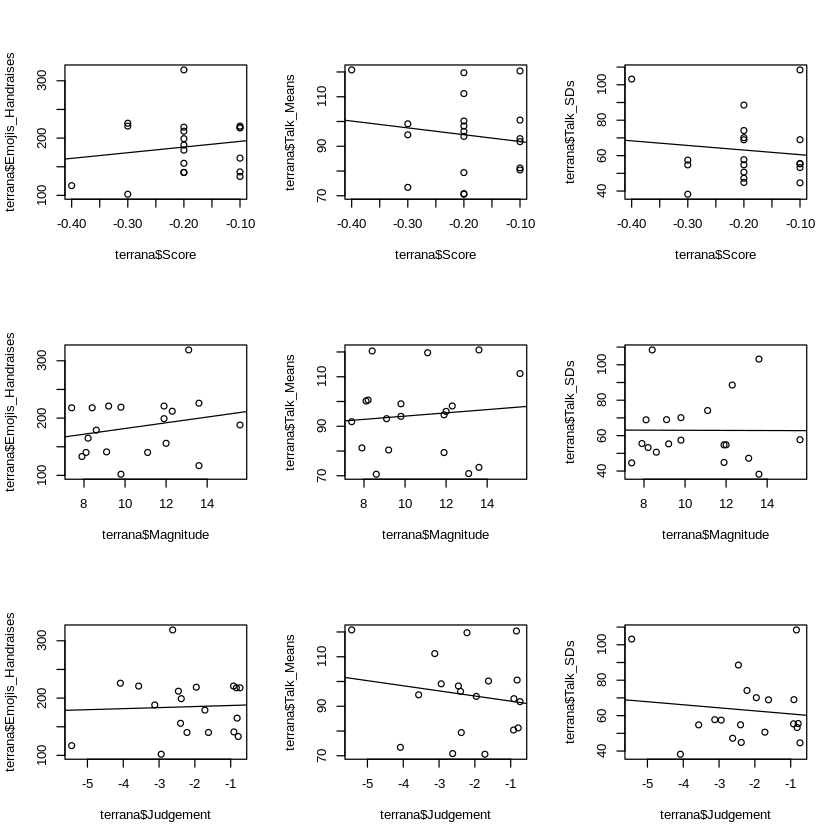

In [ ]:
par(mfrow=c(3,3))
 
#Score
plot(terrana$Emojis_Handraises~terrana$Score)
abline(terrana_score_1)
 
plot(terrana$Talk_Means~terrana$Score)
abline(terrana_score_2)
 
plot(terrana$Talk_SDs~terrana$Score)
abline(terrana_score_3)
 
#Magnitude
plot(terrana$Emojis_Handraises~terrana$Magnitude)
abline(terrana_mag_1)
 
plot(terrana$Talk_Means~terrana$Magnitude)
abline(terrana_mag_2)
 
plot(terrana$Talk_SDs~terrana$Magnitude)
abline(terrana_mag_3)
 
#Judgement
plot(terrana$Emojis_Handraises~terrana$Judgement)
abline(terrana_judge_1)
 
plot(terrana$Talk_Means~terrana$Judgement)
abline(terrana_judge_2)
 
plot(terrana$Talk_SDs~terrana$Judgement)
abline(terrana_judge_3)

## Genetic Matching and Causation

### Effect of Judgement on Talk-Time SD

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
#library(rbounds)
#library(rgenoud)

##Defining Treatment and Control
foo = read.csv("terrana.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Talk_SDs
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", replace = TRUE, pop.size = 500, print.level=0)
mout_tts_terrana = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_tts_terrana)


Estimate...  20.628 
AI SE......  19.129 
T-stat.....  1.0783 
p.val......  0.28088 

Original number of observations..............  11 
Original number of treated obs...............  2 
Matched number of observations...............  2 
Matched number of observations  (unweighted).  2 



In [ ]:
mb_ttsd_terrana = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, match.out = mout_tts_terrana, print.level=0)
mb_ttsd_terrana$AMsmallest.p.value

[1] 0.3285583

### Effect of Judgement on Emojis/Handraises

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
#library(rbounds)
#library(rgenoud)

##Defining Treatment and Control
foo = read.csv("terrana.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Emojis_Handraises
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", replace = TRUE, pop.size = 500, print.level=0)
mout_eh_terrana = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_eh_terrana)


Estimate...  -4 
AI SE......  8.4853 
T-stat.....  -0.4714 
p.val......  0.63735 

Original number of observations..............  11 
Original number of treated obs...............  2 
Matched number of observations...............  2 
Matched number of observations  (unweighted).  2 



In [ ]:
mb_eh_terrana = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, match.out = mout_eh_terrana, print.level=0)
mb_eh_terrana$AMsmallest.p.value

[1] 0.3285583

# Prof Dosmann

In [ ]:
dosmann = read.csv("dosmann.csv")

## Building the CSV File

In [ ]:
dosmann = read.csv("Dosmann_results.csv")
dosmann = prof_talk_times(dosmann, "Andy Dosmann ")

Warning message in file(file, "rt"):
“cannot open file 'Dosmann_results.csv': No such file or directory”


ERROR: ignored

In [ ]:
foo = read.csv("emoji_hands.csv")
dates = unique(foo$Class.Date)
dates = dates[-(1:7)]
dates = rev(dates)
foo = foo[foo$Class.Date %in% dates,]
events <- c()
for (i in dates){
  events <- c(events, length(foo[foo$Class.Date==i,1]))
}

dosmann$Emojis_Handraises = events

In [ ]:
write.csv(dosmann, "dosmann.csv")

## Score Correlation Analysis

### Emojis/Handraises


In [ ]:
dosmann_score_1 = lm(dosmann$Emojis_Handraises~dosmann$Score)
summary(dosmann_score_1)


Call:
lm(formula = dosmann$Emojis_Handraises ~ dosmann$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-82.553 -35.025  -8.553  11.063 174.269 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     155.55      23.40   6.647 4.12e-06 ***
dosmann$Score    64.11     129.54   0.495    0.627    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 58.99 on 17 degrees of freedom
Multiple R-squared:  0.0142,	Adjusted R-squared:  -0.04378 
F-statistic: 0.2449 on 1 and 17 DF,  p-value: 0.627


### Talk Time Mean

In [ ]:
dosmann_score_2 = lm(dosmann$Talk_Means~dosmann$Score)
summary(dosmann_score_2)


Call:
lm(formula = dosmann$Talk_Means ~ dosmann$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.454 -12.157  -4.366  12.342  27.130 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     93.626      6.345  14.755 4.02e-11 ***
dosmann$Score  -23.278     35.126  -0.663    0.516    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16 on 17 degrees of freedom
Multiple R-squared:  0.02518,	Adjusted R-squared:  -0.03216 
F-statistic: 0.4392 on 1 and 17 DF,  p-value: 0.5164


### Talk Time SD

In [ ]:
dosmann_score_3 = lm(dosmann$Talk_SDs~dosmann$Score)
summary(dosmann_score_3)


Call:
lm(formula = dosmann$Talk_SDs ~ dosmann$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-37.266 -12.193  -2.259  18.003  30.113 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     74.322      7.924   9.379 3.93e-08 ***
dosmann$Score   21.605     43.868   0.493    0.629    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.98 on 17 degrees of freedom
Multiple R-squared:  0.01407,	Adjusted R-squared:  -0.04393 
F-statistic: 0.2426 on 1 and 17 DF,  p-value: 0.6287


## Magnitude Analysis

### Emojis/Handraises


In [ ]:
dosmann_mag_1 = lm(dosmann$Emojis_Handraises~dosmann$Magnitude)
summary(dosmann_mag_1)


Call:
lm(formula = dosmann$Emojis_Handraises ~ dosmann$Magnitude)

Residuals:
   Min     1Q Median     3Q    Max 
-72.98 -39.58 -14.68  14.14 170.91 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)   
(Intercept)       145.2394    46.0674   3.153  0.00581 **
dosmann$Magnitude   0.1103     5.6038   0.020  0.98453   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 59.41 on 17 degrees of freedom
Multiple R-squared:  2.277e-05,	Adjusted R-squared:  -0.0588 
F-statistic: 0.0003872 on 1 and 17 DF,  p-value: 0.9845


### Talk Time Mean

In [ ]:
dosmann_mag_2 = lm(dosmann$Talk_Means~dosmann$Magnitude)
summary(dosmann_mag_2)


Call:
lm(formula = dosmann$Talk_Means ~ dosmann$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-24.790 -11.193  -2.246   9.931  28.801 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        108.852     12.200   8.923 8.01e-08 ***
dosmann$Magnitude   -1.502      1.484  -1.012    0.326    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.73 on 17 degrees of freedom
Multiple R-squared:  0.05685,	Adjusted R-squared:  0.001366 
F-statistic: 1.025 on 1 and 17 DF,  p-value: 0.3256


### Talk Time SD

In [ ]:
dosmann_mag_3 = lm(dosmann$Talk_SDs~dosmann$Magnitude)
summary(dosmann_mag_3)


Call:
lm(formula = dosmann$Talk_SDs ~ dosmann$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-40.096 -11.007  -2.758  19.194  29.072 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         85.198     15.186   5.610 3.12e-05 ***
dosmann$Magnitude   -1.790      1.847  -0.969    0.346    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.58 on 17 degrees of freedom
Multiple R-squared:  0.05237,	Adjusted R-squared:  -0.003378 
F-statistic: 0.9394 on 1 and 17 DF,  p-value: 0.346


## Judgement Analysis

### Emojis/Handraises


In [ ]:
dosmann_judge_1 = lm(dosmann$Emojis_Handraises~dosmann$Judgement)
summary(dosmann_judge_1)


Call:
lm(formula = dosmann$Emojis_Handraises ~ dosmann$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-80.281 -37.806  -6.281  13.416 172.545 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        153.281     20.813   7.365  1.1e-06 ***
dosmann$Judgement    5.731     12.618   0.454    0.655    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 59.06 on 17 degrees of freedom
Multiple R-squared:  0.01199,	Adjusted R-squared:  -0.04613 
F-statistic: 0.2063 on 1 and 17 DF,  p-value: 0.6555


### Talk Time Mean

In [ ]:
dosmann_judge_2 = lm(dosmann$Talk_Means~dosmann$Judgement)
summary(dosmann_judge_2)


Call:
lm(formula = dosmann$Talk_Means ~ dosmann$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.365 -12.987  -3.982  10.697  29.368 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        96.7054     5.7084  16.941 4.43e-12 ***
dosmann$Judgement  -0.2804     3.4608  -0.081    0.936    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.2 on 17 degrees of freedom
Multiple R-squared:  0.0003859,	Adjusted R-squared:  -0.05841 
F-statistic: 0.006563 on 1 and 17 DF,  p-value: 0.9364


### Talk Time SD

In [ ]:
dosmann_judge_3 = lm(dosmann$Talk_SDs~dosmann$Judgement)
summary(dosmann_judge_3)


Call:
lm(formula = dosmann$Talk_SDs ~ dosmann$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-38.709 -10.681  -0.286  18.246  29.031 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         75.667      6.941  10.901 4.31e-09 ***
dosmann$Judgement    3.617      4.208   0.859    0.402    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.7 on 17 degrees of freedom
Multiple R-squared:  0.04164,	Adjusted R-squared:  -0.01473 
F-statistic: 0.7386 on 1 and 17 DF,  p-value: 0.4021


## Plots

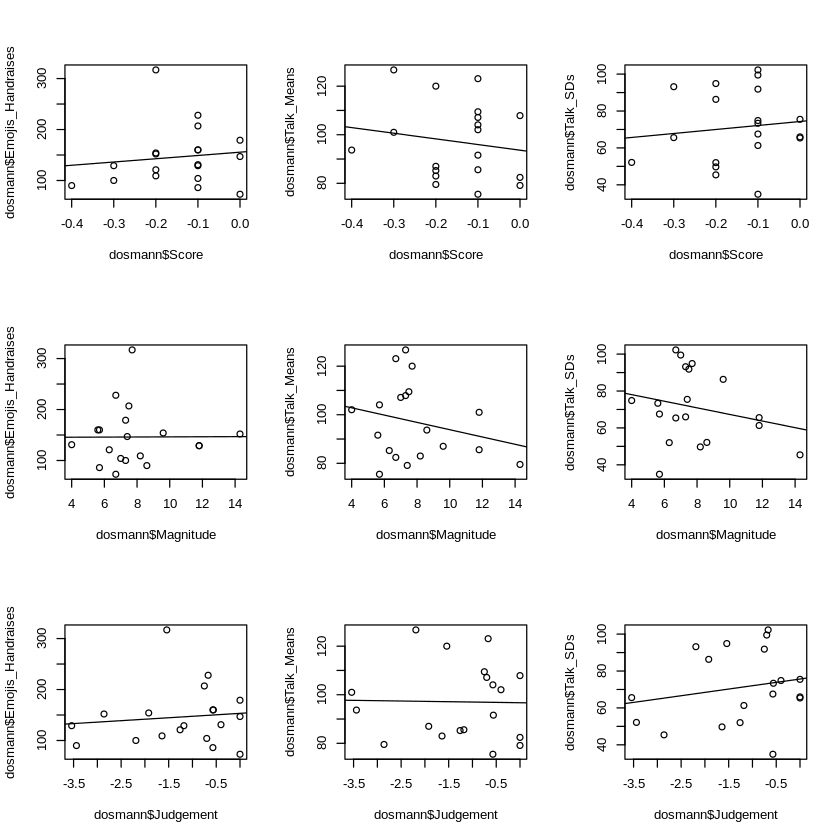

In [ ]:
par(mfrow=c(3,3))
 
#Score
plot(dosmann$Emojis_Handraises~dosmann$Score)
abline(dosmann_score_1)
 
plot(dosmann$Talk_Means~dosmann$Score)
abline(dosmann_score_2)
 
plot(dosmann$Talk_SDs~dosmann$Score)
abline(dosmann_score_3)
 
#Magnitude
plot(dosmann$Emojis_Handraises~dosmann$Magnitude)
abline(dosmann_mag_1)
 
plot(dosmann$Talk_Means~dosmann$Magnitude)
abline(dosmann_mag_2)
 
plot(dosmann$Talk_SDs~dosmann$Magnitude)
abline(dosmann_mag_3)
 
#Judgement
plot(dosmann$Emojis_Handraises~dosmann$Judgement)
abline(dosmann_judge_1)
 
plot(dosmann$Talk_Means~dosmann$Judgement)
abline(dosmann_judge_2)
 
plot(dosmann$Talk_SDs~dosmann$Judgement)
abline(dosmann_judge_3)

## Genetic Matching and Causation

### Effect of Judgement on Talk-Time SD

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
#library(rbounds)
#library(rgenoud)

##Defining Treatment and Control
foo = read.csv("dosmann.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Talk_SDs
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", pop.size=500, print.level = 0, replace = TRUE)
mout_ttsd_dosmann = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_ttsd_dosmann)



Estimate...  16.561 
AI SE......  0.48622 
T-stat.....  34.06 
p.val......  < 2.22e-16 

Original number of observations..............  12 
Original number of treated obs...............  2 
Matched number of observations...............  2 
Matched number of observations  (unweighted).  2 



In [ ]:
mb_ttsd_dosman = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, print.level = 0, match.out = mout_ttsd_dosmann)
mb_ttsd_dosman$AMsmallest.p.value

[1] 0.2015681

### Effect of Judgement on Emojis/Handraises

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
#library(rbounds)
#library(rgenoud)

##Defining Treatment and Control
foo = read.csv("dosmann.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Emojis_Handraises
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", pop.size=500, print.level = 0, replace = TRUE)
mout_eh_dosmann = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_eh_dosmann)


Estimate...  12 
AI SE......  5.6569 
T-stat.....  2.1213 
p.val......  0.033895 

Original number of observations..............  12 
Original number of treated obs...............  2 
Matched number of observations...............  2 
Matched number of observations  (unweighted).  2 



In [ ]:
mb_eh_dosmann = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, print.level = 0, match.out = mout_eh_dosmann)
mb_eh_dosmann$AMsmallest.p.value

[1] 0.188

# Prof Fiorelli

In [ ]:
fiorelli = read.csv("fiorelli.csv")

## Building the CSV File



In [ ]:
fiorelli = read.csv("Fiorelli_results.csv")
fiorelli = prof_talk_times(fiorelli, "Lindsey Fiorelli ")

In [ ]:
foo = read.csv("emoji_hands.csv")
dates = unique(foo$Class.Date)
dates = dates[-(1:7)]
dates = rev(dates)
foo = foo[foo$Class.Date %in% dates,]
events <- c()
for (i in dates){
  events <- c(events, length(foo[foo$Class.Date==i,1]))
}

fiorelli$Emojis_Handraises = events

In [ ]:
write.csv(fiorelli, "fiorelli.csv")

## Score Correlation Analysis

### Emojis/Handraises


In [ ]:
fiorelli_score_1 = lm(fiorelli$Emojis_Handraises~fiorelli$Score)
summary(fiorelli_score_1)


Call:
lm(formula = fiorelli$Emojis_Handraises ~ fiorelli$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-79.847 -36.466  -4.657  25.391 116.343 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      235.85      22.39   10.53 7.19e-09 ***
fiorelli$Score   110.95      82.19    1.35    0.195    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 54.32 on 17 degrees of freedom
Multiple R-squared:  0.09682,	Adjusted R-squared:  0.04369 
F-statistic: 1.822 on 1 and 17 DF,  p-value: 0.1947


### Talk Time Mean

In [ ]:
fiorelli_score_2 = lm(fiorelli$Talk_Means~fiorelli$Score)
summary(fiorelli_score_2)


Call:
lm(formula = fiorelli$Talk_Means ~ fiorelli$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.209 -16.678  -0.923   7.603  66.522 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     129.923     10.531  12.337 6.58e-10 ***
fiorelli$Score   -4.795     38.658  -0.124    0.903    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25.55 on 17 degrees of freedom
Multiple R-squared:  0.0009043,	Adjusted R-squared:  -0.05787 
F-statistic: 0.01539 on 1 and 17 DF,  p-value: 0.9027


### Talk Time SD

In [ ]:
fiorelli_score_3 = lm(fiorelli$Talk_SDs~fiorelli$Score)
summary(fiorelli_score_3)


Call:
lm(formula = fiorelli$Talk_SDs ~ fiorelli$Score)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.550 -11.193  -6.562   8.518  85.940 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)       83.17      10.96   7.591  7.4e-07 ***
fiorelli$Score    33.94      40.22   0.844     0.41    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.58 on 17 degrees of freedom
Multiple R-squared:  0.04021,	Adjusted R-squared:  -0.01625 
F-statistic: 0.7122 on 1 and 17 DF,  p-value: 0.4104


## Magnitude Analysis

### Emojis/Handraises


In [ ]:
fiorelli_mag_1 = lm(fiorelli$Emojis_Handraises~fiorelli$Magnitude)
summary(fiorelli_mag_1)


Call:
lm(formula = fiorelli$Emojis_Handraises ~ fiorelli$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-62.694 -48.692  -1.773  24.477 115.742 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         235.195     53.757   4.375 0.000413 ***
fiorelli$Magnitude   -1.774      3.784  -0.469 0.645053    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 56.79 on 17 degrees of freedom
Multiple R-squared:  0.01277,	Adjusted R-squared:  -0.0453 
F-statistic: 0.2199 on 1 and 17 DF,  p-value: 0.6451


### Talk Time Mean

In [ ]:
fiorelli_mag_2 = lm(fiorelli$Talk_Means~fiorelli$Magnitude)
summary(fiorelli_mag_2)


Call:
lm(formula = fiorelli$Talk_Means ~ fiorelli$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.355 -17.970  -1.974   8.229  65.009 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        133.2043    24.1893   5.507 3.85e-05 ***
fiorelli$Magnitude  -0.1593     1.7025  -0.094    0.927    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25.56 on 17 degrees of freedom
Multiple R-squared:  0.0005149,	Adjusted R-squared:  -0.05828 
F-statistic: 0.008757 on 1 and 17 DF,  p-value: 0.9265


### Talk Time SD

In [ ]:
fiorelli_mag_3 = lm(fiorelli$Talk_SDs~fiorelli$Magnitude)
summary(fiorelli_mag_3)


Call:
lm(formula = fiorelli$Talk_SDs ~ fiorelli$Magnitude)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.407 -10.739  -5.309   8.419  89.863 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)          94.787     25.225   3.758  0.00157 **
fiorelli$Magnitude   -1.400      1.775  -0.789  0.44121   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.65 on 17 degrees of freedom
Multiple R-squared:  0.03529,	Adjusted R-squared:  -0.02146 
F-statistic: 0.6219 on 1 and 17 DF,  p-value: 0.4412


## Judgement Analysis

### Emojis/Handraises


In [ ]:
fiorelli_judge_1 = lm(fiorelli$Emojis_Handraises~fiorelli$Judgement)
summary(fiorelli_judge_1)


Call:
lm(formula = fiorelli$Emojis_Handraises ~ fiorelli$Judgement)

Residuals:
   Min     1Q Median     3Q    Max 
-73.47 -44.57  -4.87  25.56 113.49 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         229.467     20.045  11.448 2.06e-09 ***
fiorelli$Judgement    5.492      4.573   1.201    0.246    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 54.88 on 17 degrees of freedom
Multiple R-squared:  0.07819,	Adjusted R-squared:  0.02397 
F-statistic: 1.442 on 1 and 17 DF,  p-value: 0.2463


### Talk Time Mean

In [ ]:
fiorelli_judge_2 = lm(fiorelli$Talk_Means~fiorelli$Judgement)
summary(fiorelli_judge_2)


Call:
lm(formula = fiorelli$Talk_Means ~ fiorelli$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-35.245 -16.604  -0.959   7.535  66.486 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        129.9588     9.3310  13.928 9.99e-11 ***
fiorelli$Judgement  -0.3077     2.1290  -0.145    0.887    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25.55 on 17 degrees of freedom
Multiple R-squared:  0.001227,	Adjusted R-squared:  -0.05752 
F-statistic: 0.02088 on 1 and 17 DF,  p-value: 0.8868


### Talk Time SD

In [ ]:
fiorelli_judge_3 = lm(fiorelli$Talk_SDs~fiorelli$Judgement)
summary(fiorelli_judge_3)


Call:
lm(formula = fiorelli$Talk_SDs ~ fiorelli$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-40.314  -9.808  -6.802   7.996  88.176 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          80.933      9.764   8.289 2.24e-07 ***
fiorelli$Judgement    1.596      2.228   0.717    0.483    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.73 on 17 degrees of freedom
Multiple R-squared:  0.02932,	Adjusted R-squared:  -0.02777 
F-statistic: 0.5136 on 1 and 17 DF,  p-value: 0.4833


### Plots

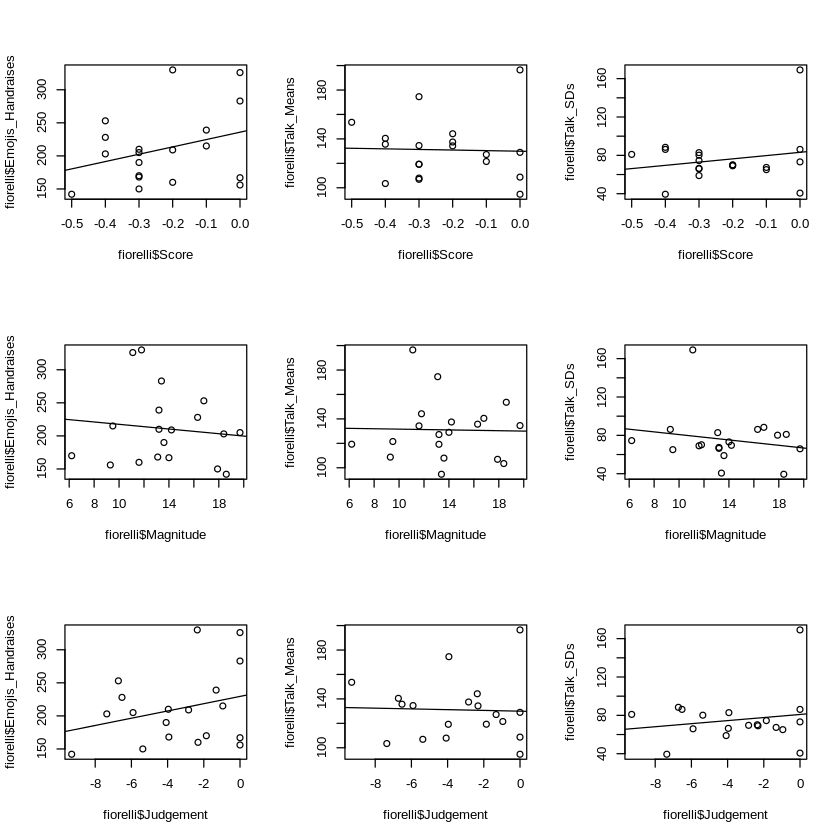

In [ ]:
par(mfrow=c(3,3))
 
#Score
plot(fiorelli$Emojis_Handraises~fiorelli$Score)
abline(fiorelli_score_1)
 
plot(fiorelli$Talk_Means~fiorelli$Score)
abline(fiorelli_score_2)
 
plot(fiorelli$Talk_SDs~fiorelli$Score)
abline(fiorelli_score_3)
 
#Magnitude
plot(fiorelli$Emojis_Handraises~fiorelli$Magnitude)
abline(fiorelli_mag_1)
 
plot(fiorelli$Talk_Means~fiorelli$Magnitude)
abline(fiorelli_mag_2)
 
plot(fiorelli$Talk_SDs~fiorelli$Magnitude)
abline(fiorelli_mag_3)
 
#Judgement
plot(fiorelli$Emojis_Handraises~fiorelli$Judgement)
abline(fiorelli_judge_1)
 
plot(fiorelli$Talk_Means~fiorelli$Judgement)
abline(fiorelli_judge_2)
 
plot(fiorelli$Talk_SDs~fiorelli$Judgement)
abline(fiorelli_judge_3)

## Genetic Matching and Causation

### Effect of Judgement on Talk-Time SD

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
library(rbounds)
library(rgenoud)

##Defining Treatment and Control
foo = read.csv("fiorelli.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Talk_SDs
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", print.level=0, pop.size = 500, replace = TRUE)
mout_ttsd_fiorelli = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_ttsd_fiorelli)


Estimate...  0.58918 
AI SE......  6.7836 
T-stat.....  0.086855 
p.val......  0.93079 

Original number of observations..............  13 
Original number of treated obs...............  4 
Matched number of observations...............  4 
Matched number of observations  (unweighted).  4 



In [ ]:
mb_ttsd_fiorelli = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, print.level = 0, match.out = mout_ttsd_fiorelli)
mb_ttsd_fiorelli$AMsmallest.p.value

[1] 0.328

### Effect of Judgement on Emojis/Handraises

In [ ]:
##Installing required packages
#install.packages("rbounds")
#install.packages("rgenoud")
library(rbounds)
library(rgenoud)

##Defining Treatment and Control
foo = read.csv("fiorelli.csv")

treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
control = foo$Judgement>(mean(foo$Judgement)-sd(foo$Judgement))
vars = treat|control
foo = foo[vars,]
foo$Treat = foo$Judgement<(mean(foo$Judgement)-sd(foo$Judgement))
foo$AvgGrade = mean(c(foo$Prep.Mean, foo$Video.Mean))
foo$AvgGradeSD = mean(c(foo$Video.SD, foo$Prep.SD))

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.Mean[i])){
    foo$AvgGrade[i] = foo$Prep.Mean[i]
  } else if (is.na(foo$Prep.Mean[i])){
    foo$AvgGrade[i] = foo$Video.Mean[i]
  } else {
    foo$AvgGrade[i] = mean(c(foo$Prep.Mean[i], foo$Video.Mean[i]))
  }
}

for (i in 1:length(foo$Treat)){
  if (is.na(foo$Video.SD[i])){
    foo$AvgGradeSD[i] = foo$Prep.SD[i]
  } else if (is.na(foo$Prep.SD[i])){
    foo$AvgGradeSD[i] = foo$Video.SD[i]
  } else {
    foo$AvgGradeSD[i] = mean(c(foo$Prep.SD[i], foo$Video.SD[i]))
  }
}
foo = foo[!is.na(foo$AvgGrade),]


Y = foo$Emojis_Handraises
Tr = foo$Treat
X = cbind(foo$Class.Date, foo$Number.of.Students, foo$AvgGrade, foo$AvgGradeSD)
genout = GenMatch(Tr=Tr, X=X, estimand = "ATT", print.level=0, pop.size = 500, replace = TRUE)
mout_eh_fiorelli = Match(Tr = Tr, Y=Y, X=X, estimand = "ATT", replace = TRUE, Weight.matrix = genout)
summary(mout_eh_fiorelli)


Estimate...  22.75 
AI SE......  21.927 
T-stat.....  1.0375 
p.val......  0.29949 

Original number of observations..............  13 
Original number of treated obs...............  4 
Matched number of observations...............  4 
Matched number of observations  (unweighted).  4 



In [ ]:
mb_eh_fiorelli = MatchBalance(foo$Treat~foo$Class.Date+foo$Number.of.Students+foo$AvgGrade+foo$AvgGradeSD, print.level = 0, match.out = mout_eh_fiorelli)
mb_eh_fiorelli$AMsmallest.p.value

[1] 0.312

# Summary

In [ ]:
mout_ttsd_mcallister
mout_ttsd_terrana
mout_ttsd_dosmann
mout_ttsd_fiorelli

mout_eh_mcallister
mout_eh_terrana
mout_eh_dosmann
mout_eh_fiorelli

mb_ttsd_mcallister$AMsmallest.p.value
mb_ttsd_terrana$AMsmallest.p.value
mb_ttsd_dosmann$AMsmallest.p.value
mb_ttsd_fiorelli$AMsmallest.p.value

mb_eh_mcallister$AMsmallest.p.value
mb_eh_terrana$AMsmallest.p.value
mb_eh_dosmann$AMsmallest.p.value
mb_eh_fiorelli$AMsmallest.p.value

In [ ]:
mcallister

...1,Class,Score,Magnitude,Judgement,Talk_Means,Talk_SDs,Emojis_Handraises,Video.Mean,Video.SD,Prep.Mean,Prep.SD,Class.Date,Number.of.Students
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
0,Class_1.1.wav,-0.1,5.5,-0.55,147.37500,83.12230,86,3.578947,0.4937280,NA,NA,1/13/2020,18
1,Class_1.2.wav,-0.2,8.4,-1.68,133.00000,55.38050,124,NA,NA,3.105263,0.3068922,1/15/2020,19
2,Class_2.1.wav,-0.3,9.7,-2.91,150.73333,108.22032,133,3.333333,0.5962848,NA,NA,1/20/2020,17
3,Class_2.2.wav,-0.3,8.8,-2.64,132.00000,91.15116,118,NA,NA,3.650000,0.4769696,1/22/2020,18
4,Class_3.1.wav,-0.4,10.4,-4.16,140.05882,63.18868,167,3.578947,0.4937280,NA,NA,1/27/2020,19
5,Class_3.2.wav,-0.2,9.3,-1.86,119.52941,74.10222,148,NA,NA,NA,NA,1/29/2020,19
6,Class_4.1.wav,-0.3,6.2,-1.86,118.00000,55.33921,98,NA,NA,NA,NA,2/3/2020,17
7,Class_4.2.wav,-0.2,10.2,-2.04,160.81250,119.68916,131,3.714286,0.4517540,NA,NA,2/5/2020,18
8,Class_5.1.wav,0.0,6.7,0.00,109.00000,83.23140,91,3.421053,0.4937280,3.000000,0.0000000,2/10/2020,18


In [ ]:
cols = c("Emojis_Handraises", "Talk_Means", "Talk_SDs")

for (i in cols){
  model = lm(mcallister[[i]]~mcallister$Judgement)
  print(paste("Results for:", i))
  print(summary(model))
}


[1] "Results for: Emojis_Handraises"

Call:
lm(formula = mcallister[[i]] ~ mcallister$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.914 -15.979  -1.721  12.079  56.279 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           105.721      8.213  12.872 3.42e-10 ***
mcallister$Judgement  -11.181      4.773  -2.343   0.0316 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 22.86 on 17 degrees of freedom
Multiple R-squared:  0.244,	Adjusted R-squared:  0.1996 
F-statistic: 5.488 on 1 and 17 DF,  p-value: 0.03157

[1] "Results for: Talk_Means"

Call:
lm(formula = mcallister[[i]] ~ mcallister$Judgement)

Residuals:
    Min      1Q  Median      3Q     Max 
-48.746 -21.166  -1.841  11.127 108.219 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           146.951     13.111  11.208 2.84e-09 ***
mcallister$Judgement    4.966      7.619   0.652  

In [ ]:
mcallister

...1,Class,Score,Magnitude,Judgement,Talk_Means,Talk_SDs,Emojis_Handraises,Video.Mean,Video.SD,Prep.Mean,Prep.SD,Class.Date,Number.of.Students
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
0,Class_1.1.wav,-0.1,5.5,-0.55,147.37500,83.12230,86,3.578947,0.4937280,NA,NA,1/13/2020,18
1,Class_1.2.wav,-0.2,8.4,-1.68,133.00000,55.38050,124,NA,NA,3.105263,0.3068922,1/15/2020,19
2,Class_2.1.wav,-0.3,9.7,-2.91,150.73333,108.22032,133,3.333333,0.5962848,NA,NA,1/20/2020,17
3,Class_2.2.wav,-0.3,8.8,-2.64,132.00000,91.15116,118,NA,NA,3.650000,0.4769696,1/22/2020,18
4,Class_3.1.wav,-0.4,10.4,-4.16,140.05882,63.18868,167,3.578947,0.4937280,NA,NA,1/27/2020,19
5,Class_3.2.wav,-0.2,9.3,-1.86,119.52941,74.10222,148,NA,NA,NA,NA,1/29/2020,19
6,Class_4.1.wav,-0.3,6.2,-1.86,118.00000,55.33921,98,NA,NA,NA,NA,2/3/2020,17
7,Class_4.2.wav,-0.2,10.2,-2.04,160.81250,119.68916,131,3.714286,0.4517540,NA,NA,2/5/2020,18
8,Class_5.1.wav,0.0,6.7,0.00,109.00000,83.23140,91,3.421053,0.4937280,3.000000,0.0000000,2/10/2020,18


In [ ]:
te = gen_matching(terrana, 'Emojis_Handraises')

[1] 0.3285583

Estimate...  -4 
AI SE......  8.4853 
T-stat.....  -0.4714 
p.val......  0.63735 

Original number of observations..............  11 
Original number of treated obs...............  2 
Matched number of observations...............  2 
Matched number of observations  (unweighted).  2 



In [ ]:
dataframes = list(mcallister, terrana, dosmann, fiorelli)

#mc = gen_matching(mcallister, "Talk_SDs")
for (j in dataframes){
  print(deparse(substitute(j)))
  for (i in cols){
  print(paste("Results for:", i))
  results = gen_matching(j, i)
  }
}


#te = gen_matching(terrana, "Talk_Means")
#do = gen_matching(dosmann, "Talk_SDs")
#fi = gen_matching(fiorelli, "Talk_SDs")


[1] "j"
[1] "Results for: Emojis_Handraises"
[1] 0.3453463

Estimate...  37.667 
AI SE......  4.4333 
T-stat.....  8.4963 
p.val......  < 2.22e-16 

Original number of observations..............  14 
Original number of treated obs...............  3 
Matched number of observations...............  3 
Matched number of observations  (unweighted).  3 

[1] "Results for: Talk_Means"
[1] 0.3453463

Estimate...  8.3082 
AI SE......  14.429 
T-stat.....  0.57581 
p.val......  0.56474 

Original number of observations..............  14 
Original number of treated obs...............  3 
Matched number of observations...............  3 
Matched number of observations  (unweighted).  3 

[1] "Results for: Talk_SDs"
[1] 0.3453463

Estimate...  15.569 
AI SE......  4.7392 
T-stat.....  3.2853 
p.val......  0.0010189 

Original number of observations..............  14 
Original number of treated obs...............  3 
Matched number of observations...............  3 
Matched number of observations  (

In [ ]:
mcallister

...1,Class,Score,Magnitude,Judgement,Talk_Means,Talk_SDs,Emojis_Handraises,Video.Mean,Video.SD,Prep.Mean,Prep.SD,Class.Date,Number.of.Students
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
0,Class_1.1.wav,-0.1,5.5,-0.55,147.37500,83.12230,86,3.578947,0.4937280,NA,NA,1/13/2020,18
1,Class_1.2.wav,-0.2,8.4,-1.68,133.00000,55.38050,124,NA,NA,3.105263,0.3068922,1/15/2020,19
2,Class_2.1.wav,-0.3,9.7,-2.91,150.73333,108.22032,133,3.333333,0.5962848,NA,NA,1/20/2020,17
3,Class_2.2.wav,-0.3,8.8,-2.64,132.00000,91.15116,118,NA,NA,3.650000,0.4769696,1/22/2020,18
4,Class_3.1.wav,-0.4,10.4,-4.16,140.05882,63.18868,167,3.578947,0.4937280,NA,NA,1/27/2020,19
5,Class_3.2.wav,-0.2,9.3,-1.86,119.52941,74.10222,148,NA,NA,NA,NA,1/29/2020,19
6,Class_4.1.wav,-0.3,6.2,-1.86,118.00000,55.33921,98,NA,NA,NA,NA,2/3/2020,17
7,Class_4.2.wav,-0.2,10.2,-2.04,160.81250,119.68916,131,3.714286,0.4517540,NA,NA,2/5/2020,18
8,Class_5.1.wav,0.0,6.7,0.00,109.00000,83.23140,91,3.421053,0.4937280,3.000000,0.0000000,2/10/2020,18


In [ ]:
lst <- c("Talk_Means", "Talk_SDs", "Emojis_Handraises")
mc_sens = c()
te_sens = c()
do_sens = c()
fi_sens = c()

for (i in lst){
  mc = psens(gen_matching("mcallister.csv", i), Gamma=3, GammaInc=0.5)
  te = psens(gen_matching("terrana.csv", i), Gamma=3, GammaInc=0.5)
  do = psens(gen_matching("dosmann.csv", i), Gamma=3, GammaInc=0.5)
  fi = psens(gen_matching("fiorelli.csv", i), Gamma=3, GammaInc=0.5)
  mc_sens = append(mc_sens, mc)
  te_sens = append(te_sens, te)
  do_sens = append(do_sens, do)
  fi_sens = append(fi_sens, fi)
}



[1] 0.3453463

Estimate...  8.3082 
AI SE......  14.429 
T-stat.....  0.57581 
p.val......  0.56474 

Original number of observations..............  14 
Original number of treated obs...............  3 
Matched number of observations...............  3 
Matched number of observations  (unweighted).  3 

[1] 0.6923937

Estimate...  0.8553 
AI SE......  6.1556 
T-stat.....  0.13895 
p.val......  0.88949 

Original number of observations..............  11 
Original number of treated obs...............  2 
Matched number of observations...............  2 
Matched number of observations  (unweighted).  2 

[1] 0.188

Estimate...  -3.75 
AI SE......  20.683 
T-stat.....  -0.18131 
p.val......  0.85612 

Original number of observations..............  12 
Original number of treated obs...............  2 
Matched number of observations...............  2 
Matched number of observations  (unweighted).  2 

[1] 0.5344903

Estimate...  8.4368 
AI SE......  10.103 
T-stat.....  0.83511 
p.val......  

In [ ]:
fi_sens

Gamma,Lower bound,Upper bound
<dbl>,<dbl>,<dbl>
1.0,0.2326,0.2326
1.5,0.1318,0.3547
2.0,0.0778,0.4486
2.5,0.0470,0.5230
3.0,0.0289,0.5835
Gamma,Lower bound,Upper bound
<dbl>,<dbl>,<dbl>
1.0,0.3575,0.3575
1.5,0.2280,0.5000


In [ ]:
dates = as.Date(mcallister$Class.Date, "%m/%d/%Y")
numerics = as.numeric(dates)
numerics

[1] 18274 18276 18281 18283 18288 18290 18295 18297 18302 18304 18311 18316
[13] 18318 18323 18325 18330 18332 18337 18339

In [ ]:
install.packages("rbounds")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
mcallister

...1,Class,Score,Magnitude,Judgement,Talk_Means,Talk_SDs,Emojis_Handraises,Video.Mean,Video.SD,Prep.Mean,Prep.SD,Class.Date,Number.of.Students
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
0,Class_1.1.wav,-0.1,5.5,-0.55,147.37500,83.12230,86,3.578947,0.4937280,NA,NA,1/13/2020,18
1,Class_1.2.wav,-0.2,8.4,-1.68,133.00000,55.38050,124,NA,NA,3.105263,0.3068922,1/15/2020,19
2,Class_2.1.wav,-0.3,9.7,-2.91,150.73333,108.22032,133,3.333333,0.5962848,NA,NA,1/20/2020,17
3,Class_2.2.wav,-0.3,8.8,-2.64,132.00000,91.15116,118,NA,NA,3.650000,0.4769696,1/22/2020,18
4,Class_3.1.wav,-0.4,10.4,-4.16,140.05882,63.18868,167,3.578947,0.4937280,NA,NA,1/27/2020,19
5,Class_3.2.wav,-0.2,9.3,-1.86,119.52941,74.10222,148,NA,NA,NA,NA,1/29/2020,19
6,Class_4.1.wav,-0.3,6.2,-1.86,118.00000,55.33921,98,NA,NA,NA,NA,2/3/2020,17
7,Class_4.2.wav,-0.2,10.2,-2.04,160.81250,119.68916,131,3.714286,0.4517540,NA,NA,2/5/2020,18
8,Class_5.1.wav,0.0,6.7,0.00,109.00000,83.23140,91,3.421053,0.4937280,3.000000,0.0000000,2/10/2020,18
